# PA5 - Applied Machine Learning, DIT867, sp4 2024

- Frida jacobson, gusjacof@student.gu.se
- Leo Holmgren, leoholmgren@me.com

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import nn, optim, argmax
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Check GPU runtime

In [ ]:
#check for gpu
if torch.backends.mps.is_available():
   mps_device = torch.device("mps")
   x = torch.ones(1, device=mps_device)
   print (x)
else:
   print ("MPS device not found.")


In [ ]:
# check gpu run time

import time

# GPU
start_time = time.time()

# syncrocnize time with cpu, otherwise only time for oflaoding data to gpu would be measured
torch.mps.synchronize()

a = torch.ones(4000,4000, device="mps")
for _ in range(200):
   a +=a

elapsed_time = time.time() - start_time
print( "GPU Time: ", elapsed_time)

# Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load data

transform = transforms.Compose([
    transforms.ToTensor()
])

data_train = datasets.ImageFolder('a5_data_new/train', transform=transform)
trainDataLoader = DataLoader(data_train, batch_size=256, shuffle=True)

data_val = datasets.ImageFolder('a5_data_new/val', transform=transform)
valDataLoader = DataLoader(data_val, batch_size=256, shuffle=False)

data_test = datasets.ImageFolder('a5_data_test/test', transform=transform)
testDataLoader = DataLoader(data_test, batch_size=256, shuffle=False)

Dataset ImageFolder
    Number of datapoints: 6426
    Root location: a5_data_new/train
    StandardTransform
Transform: Compose(
               ToTensor()
           ) Dataset ImageFolder
    Number of datapoints: 1252
    Root location: a5_data_new/val
    StandardTransform
Transform: Compose(
               ToTensor()
           )
3213
(128, 128, 3)
1 [[[0.9411765  0.6039216  0.64705884]
  [0.9372549  0.60784316 0.6431373 ]
  [0.94509804 0.6039216  0.6431373 ]
  ...
  [0.92941177 0.60784316 0.63529414]
  [0.9254902  0.59607846 0.6156863 ]
  [0.9254902  0.5921569  0.61960787]]

 [[0.9411765  0.6        0.6392157 ]
  [0.9372549  0.6        0.6392157 ]
  [0.9411765  0.59607846 0.6392157 ]
  ...
  [0.93333334 0.60784316 0.627451  ]
  [0.92156863 0.59607846 0.61960787]
  [0.92156863 0.5882353  0.61960787]]

 [[0.9411765  0.59607846 0.6392157 ]
  [0.9490196  0.6        0.6392157 ]
  [0.94509804 0.6        0.6313726 ]
  ...
  [0.9411765  0.6039216  0.6313726 ]
  [0.9411765  0.60784316 0.63

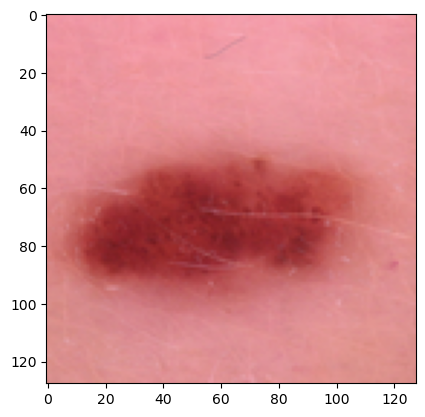

In [ ]:
# Check data

print(data_train, data_val, data_test)

all_labels = [label.item() for _, labels in trainDataLoader for label in labels]
print(len([label for label in all_labels if label == 0]))

img, label = data_val[1044]
img = img.numpy().transpose(1, 2, 0) # transpose needed to set the color dimension 3 last instead of first
print(img.shape) # 128 x 128 x 3
print(label, img) # values are tensor values between 0 and 1
plt.imshow(img)


# Functions

In [ ]:

def cnn_train(model, loss_fn, optimizer, epochs=50, trainDataLoader=trainDataLoader, valDataLoader=valDataLoader):

    acc_list = []
    loss_list = []
    loss_val_list = []

    for epoch in range(epochs):

        print('Epoch ', epoch +1)
        model.train()
        total = 0
        running_loss = 0

        for images, labels in trainDataLoader:

            optimizer.zero_grad() # Set initial gradient to 0

            output = model(images) # Use model on images
            output = output.squeeze(dim=1)
            labels = labels.float()

            loss = loss_fn(output, labels) # Calculate loss comparing predicted and true labels from train set
            loss.backward() # Calculate new weights depending on loss
            optimizer.step() # Update parameters

            total += labels.size(0)
            running_loss += loss.item() * labels.size(0)

        loss_train = running_loss / total
        loss_list.append(loss_train)

        model.eval()
        correct = 0
        val_total = 0
        val_running_loss = 0

        with torch.no_grad():
            for images, labels in valDataLoader: # Iterate through test dataset

                output = model(images) # Use model on images
                output = output.squeeze(dim=1)
                labels = labels.float()

                val_loss = loss_fn(output, labels) # Calculate loss comparing predicted and true labels from test set

                probs = torch.sigmoid(output)
                y_pred = (probs > 0.5).float()
                correct += (y_pred == labels).sum().item() # Number of correct pred, add to total
                val_total += labels.size(0) # Add batch size to total

                val_running_loss += val_loss.item() * labels.size(0)

            accuracy = correct / val_total # divide total correct by total samples
            acc_list.append(accuracy)
            loss_val_average = val_running_loss / val_total
            loss_val_list.append(loss_val_average)

        print(f'Loss: {loss_train}, Loss validation set: {loss_val_average}, Accuracy: {accuracy}')

    print('Done!')
    return acc_list, loss_list, loss_val_list


In [ ]:
from torch import nn, optim
import torch
import torch.nn.init as init
import torch.nn.utils as utils
from torchvision.models import resnet18

def cnn_gpu_train(resnet_model, num_epochs, loss_fn, optimizer):

    # Clear cache
    torch.cuda.empty_cache()

    # Custom weight initialization function
    def initialize_weights(model):
        for m in model.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


    # Modify the final layer for binary classification
    num_features = resnet_model.fc.in_features
    resnet_model.fc = nn.Linear(num_features, 1)  # Output 1 value for binary classification

    # Reinitialize weights
    initialize_weights(resnet_model)

    # Move model to the device
    resnet_model = resnet_model.to(device)

    # Initialize loss function and optimizer
    # pre_loss_fn = nn.BCEWithLogitsLoss()
    pre_loss_fn = loss_fn
    # pre_optimizer = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)  # Lowered learning rate
    pre_optimizer = optimizer # Lowered learning rate

    early_stopping = EarlyStopping(patience=5, min_delta=0.01)

    acc_list = []
    loss_list = []
    loss_val_list = []

    print('Training Data Statistics:')
    for images, labels in preTrainDataLoader:
        images, labels = images.to(device), labels.to(device).float()
        print(f'Images mean: {images.mean().item()}, std: {images.std().item()}')
        print(f'Labels mean: {labels.mean().item()}, std: {labels.std().item()}')
        break  # Just print stats for one batch to avoid excessive logging

    print('Validation Data Statistics:')
    for images, labels in preValDataLoader:
        images, labels = images.to(device), labels.to(device).float()
        print(f'Images mean: {images.mean().item()}, std: {images.std().item()}')
        print(f'Labels mean: {labels.mean().item()}, std: {labels.std().item()}')
        break  # Just print stats for one batch to avoid excessive logging

    print('Initial model weights statistics:')
    for name, param in resnet_model.named_parameters():
        if param.requires_grad:
            print(f'Layer: {name}, mean: {param.data.mean().item()}, std: {param.data.std().item()}')

    for epoch in range(num_epochs):
        print('Epoch', epoch + 1)
        total = 0
        running_loss = 0

        resnet_model.train()  # Set model to training mode

        for images, labels in preTrainDataLoader:
            images, labels = images.to(device), labels.to(device).float()

            if torch.isnan(images).any() or torch.isinf(images).any() or torch.isnan(labels).any() or torch.isinf(labels).any():
                print("Data contains nan or inf values")
                print(f"Images: {images}")
                print(f"Labels: {labels}")
                continue

            pre_optimizer.zero_grad()  # Set initial gradient to 0

            output = resnet_model(images)  # Use resnet_model on images
            output = output.squeeze(dim=1)  # Ensure proper dimensions

            if torch.isnan(output).any() or torch.isinf(output).any():
                print("Model output contains nan or inf values")
                print(f"Output: {output}")
                continue

            loss = pre_loss_fn(output, labels)  # Calculate loss comparing predicted and true labels from train set

            if torch.isnan(loss) or torch.isinf(loss):
                print("Loss contains nan or inf values")
                print(f"Loss: {loss}")
                continue

            loss.backward()  # Calculate new weights depending on loss

            for name, param in resnet_model.named_parameters():
                if param.requires_grad:
                    if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                        print(f'Gradient contains nan or inf values in layer: {name}')
                        print(f'Gradients: {param.grad}')
                        continue

            # Clip gradients to prevent exploding gradients
            utils.clip_grad_norm_(resnet_model.parameters(), max_norm=1.0)

            pre_optimizer.step()  # Update parameters

            total += labels.size(0)
            running_loss += loss.item() * labels.size(0)

        if total == 0:  # If all batches are skipped, avoid division by zero
            print("All batches were skipped, setting loss_train to NaN")
            loss_train = float('nan')
        else:
            loss_train = running_loss / total
        loss_list.append(loss_train)

        resnet_model.eval()  # Set model to evaluation mode
        correct = 0
        val_total = 0
        val_running_loss = 0

        with torch.no_grad():
            for images, labels in preValDataLoader:  # Iterate through validation dataset
                images, labels = images.to(device), labels.to(device).float()

                if torch.isnan(images).any() or torch.isinf(images).any() or torch.isnan(labels).any() or torch.isinf(labels).any():
                    print("Validation data contains nan or inf values")
                    print(f"Images: {images}")
                    print(f"Labels: {labels}")
                    continue

                output = resnet_model(images)  # Use model on images
                output = output.squeeze(dim=1)  # Ensure proper dimensions

                if torch.isnan(output).any() or torch.isinf(output).any():
                    print("Validation model output contains nan or inf values")
                    print(f"Output: {output}")
                    continue

                val_loss = pre_loss_fn(output, labels)  # Calculate loss comparing predicted and true labels from test set

                if torch.isnan(val_loss) or torch.isinf(val_loss):
                    print("Validation loss contains nan or inf values")
                    print(f"Loss: {val_loss}")
                    continue

                probs = torch.sigmoid(output)
                y_pred = (probs > 0.5).float()
                correct += (y_pred == labels).sum().item()  # Number of correct predictions
                val_total += labels.size(0)  # Add batch size to total

                val_running_loss += val_loss.item() * labels.size(0)

            if val_total == 0:  # If all batches are skipped, avoid division by zero
                print("All validation batches were skipped, setting loss_val_average to NaN")
                loss_val_average = float('nan')
            else:
                loss_val_average = val_running_loss / val_total
            loss_val_list.append(loss_val_average)

        accuracy = correct / val_total if val_total != 0 else float('nan')
        acc_list.append(accuracy)

        print(f'Loss: {loss_train}, Loss validation set: {loss_val_average}, Accuracy: {accuracy}')

         # Check early stopping condition
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f'Early stopping at epoch {epoch+1}')
            break

    print('Done!')

    return(acc_list, loss_list, loss_val_list, resnet_model)

In [ ]:
# Plotting model validation

def plot_loss_acc(acc_list, loss_list, loss_val_list, threshold=1, fig_name='acc_loss.pdf'):

    acc_list = np.array(acc_list)
    acc_high_x = np.argwhere(acc_list >= threshold).flatten() + 1
    acc_high_y = [acc for acc in acc_list if acc >= threshold]
    ax_len = len(acc_list)
    plt.plot(np.arange(1, ax_len+1), acc_list, color='orange')
    plt.scatter(acc_high_x, acc_high_y, color='red')
    plt.plot(np.arange(1, ax_len+1), loss_list, color='purple')
    plt.plot(np.arange(1, ax_len+1), loss_val_list, color='lightblue')
    plt.xlabel('Epoch', size=16)
    plt.ylabel('Accuracy, Loss', size=16)
    plt.legend(['Accuracy', f'Acc > {threshold}', 'Loss training', 'Loss validation'])
    plt.savefig(fig_name)
    plt.show()

In [ ]:
# function to evaluate the model
def predict_evaluate(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            logits = model(images).squeeze(1)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Print metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)

    return predictions, true_labels

# Using the function to get predictions and evaluate
# predictions, true_labels = predict_evaluate(model, testDataLoader)

# Baseline model

In [ ]:
# base model batch 256, ReLu for all

# define model
model_base = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), stride=1, padding=1), # Conv layer
    nn.ReLU(), # Activation function
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1), # Conv layer
    nn.ReLU(), # Activation function
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32768, 100),
    nn.ReLU(), # Activation function
    nn.Linear(100, 1)  # Single output neuron for binary classification
    # application of sigmoid in training loop before accuracy calculation only
)

# Loss function and optimizer method
loss_fn_base = nn.BCEWithLogitsLoss()
optimizer_base = optim.SGD(model_base.parameters(), lr=0.001, weight_decay=1e-4)


In [ ]:
acc_list_base, loss_list_base, loss_val_list_base = cnn_train(model_base, loss_fn_base, optimizer_base)

In [ ]:
# Plot results
plot_loss_acc(acc_list=acc_list_base, loss_list=loss_list_base, loss_val_list=loss_val_list_base ,threshold=0.70, fig_name='cnn_base.pdf')

---
# Batch normalization

In [ ]:
# Adding batch normalization for all layers, same as base otherwise

# Define model
model_bn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), stride=1, padding=1), # Conv layer
    nn.BatchNorm2d(16),
    nn.ReLU(), # Activation function
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1), # Conv layer
    nn.ReLU(), # Activation function
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32768, 100), # adjust dimenstion 7200
    nn.BatchNorm1d(100),
    nn.ReLU(), # Activation function
    nn.Linear(100, 1)  # Single output neuron for binary classification
)

# Loss function and optimizer method
loss_fn_bn = nn.BCEWithLogitsLoss()
optimizer_bn = optim.SGD(model_bn.parameters(), lr=0.001, weight_decay=1e-4)

# Train model
acc_list_bn, loss_list_bn, loss_val_list_bn = cnn_train(model_bn, loss_fn_bn, optimizer_bn)


Epoch  1
Loss: 0.49782922746160857, Loss validation set: 0.6395094383258028, Accuracy: 0.6533546325878594
Epoch  2
Loss: 0.43951186841052897, Loss validation set: 0.46750883486705086, Accuracy: 0.7691693290734825
Epoch  3
Loss: 0.4233422454294667, Loss validation set: 0.44237455263876685, Accuracy: 0.7747603833865815
Epoch  4
Loss: 0.41192809011644566, Loss validation set: 0.434238477208363, Accuracy: 0.7843450479233227
Epoch  5
Loss: 0.4041616298070475, Loss validation set: 0.42410674243689345, Accuracy: 0.799520766773163
Epoch  6
Loss: 0.39736790546478973, Loss validation set: 0.46460344587652064, Accuracy: 0.7763578274760383
Epoch  7
Loss: 0.3919225803257853, Loss validation set: 0.4186800392671896, Accuracy: 0.8011182108626198
Epoch  8
Loss: 0.38586290712635574, Loss validation set: 0.4146756619310227, Accuracy: 0.810702875399361
Epoch  9
Loss: 0.38255404906594936, Loss validation set: 0.4087939757508592, Accuracy: 0.8067092651757188
Epoch  10
Loss: 0.3757984874647724, Loss validat

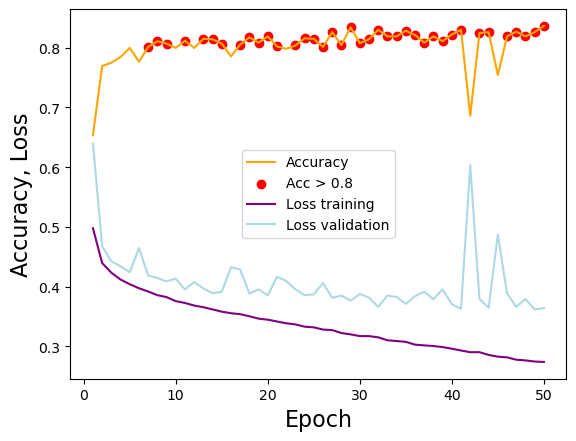

In [ ]:
# Plot results, threshold 0.80 for both bn and gn
plot_loss_acc(acc_list_bn, loss_list_bn, loss_val_list_bn, threshold=0.80, fig_name='cnn_bn.pdf')

---
# Group normalization

In [ ]:
# Trying group normalization to see if fluctuations can be decreased
# and to compare with batch norm, lr 0.001 and 50 epochs, loss_fn and optimizer as before

model_gn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
    nn.GroupNorm(num_groups=4, num_channels=16),  # Group Normalization with 4 groups
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
    nn.GroupNorm(num_groups=8, num_channels=32),  # Group Normalization with 8 groups
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(32 * 32 * 32, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
)

# Loss function and optimizer method
loss_fn_gn = nn.BCEWithLogitsLoss()
optimizer_gn = optim.SGD(model_gn.parameters(), lr=0.001, weight_decay=1e-4)

acc_list_gn, loss_list_gn, loss_val_list_gn = cnn_train(model_gn, loss_fn_gn, optimizer_gn)


Epoch  1
Loss: 0.6312958062195978, Loss validation set: 0.5852648994793146, Accuracy: 0.7100638977635783
Epoch  2
Loss: 0.5454288165479518, Loss validation set: 0.5451621748388004, Accuracy: 0.6988817891373802
Epoch  3
Loss: 0.49635335609173054, Loss validation set: 0.5325012066112921, Accuracy: 0.7172523961661342
Epoch  4
Loss: 0.470770876948573, Loss validation set: 0.47211553960943375, Accuracy: 0.7643769968051118
Epoch  5
Loss: 0.4545254568388779, Loss validation set: 0.4899606309569301, Accuracy: 0.7428115015974441
Epoch  6
Loss: 0.44482349626861406, Loss validation set: 0.45835001466754144, Accuracy: 0.7755591054313099
Epoch  7
Loss: 0.4379457937494973, Loss validation set: 0.47029622518026026, Accuracy: 0.7468051118210862
Epoch  8
Loss: 0.4351219177116236, Loss validation set: 0.45086363262642687, Accuracy: 0.7779552715654952
Epoch  9
Loss: 0.42947101076369787, Loss validation set: 0.4478095040534632, Accuracy: 0.7763578274760383
Epoch  10
Loss: 0.4255698427321419, Loss validati

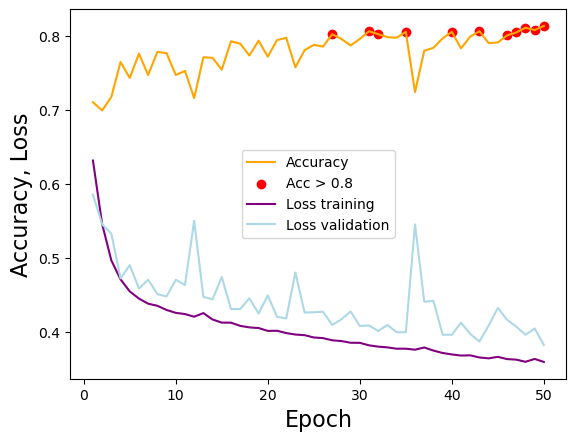

In [ ]:
plot_loss_acc(acc_list_gn, loss_list_gn, loss_val_list_gn, threshold=0.80, fig_name='cnn_gn.pdf')


---
# Adding dropout in addition to batch normalization


In [ ]:
# Tried 5x5 kernel with decrease in performance, kept kernel 3x3

# A reduction in the number of parameters can help in making the model simpler and less prone to overfitting,
# especially when the training data is limited. Therefore, the kernel size was set to 3x3 for the convolutional layers,
# keeping the number of parameters realtively low.

model_bn_dropout2 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), stride=1, padding=1), # Conv layer
    nn.BatchNorm2d(16),
    nn.ReLU(), # Activation function
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(p=0.2),

    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1), # Conv layer
    nn.BatchNorm2d(32),
    nn.ReLU(), # Activation function
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(p=0.2),

    nn.Flatten(),
    nn.Linear(32768, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(), # Activation function
    nn.Dropout(p=0.5),
    nn.Linear(100, 1)  # Single output neuron for binary classification
)

# Loss function and optimizer method
loss_fn_bn_dropout2 = nn.BCEWithLogitsLoss()
optimizer_bn_dropout2 = optim.SGD(model_bn_dropout2.parameters(), lr=0.001, weight_decay=1e-4)

acc_list_bn_drop2, loss_list_bn_drop2, loss_val_list_bn_drop2 = cnn_train(model_bn_dropout2, loss_fn_bn_dropout2, optimizer_bn_dropout2)


In [ ]:
plot_loss_acc(acc_list=acc_list_bn_drop2, loss_list=loss_list_bn_drop2, loss_val_list=loss_val_list_bn_drop2, threshold=0.81, fig_name='cnn_bn_drop.pdf')


---
# Image augmentation in addition to batch normalization and dropout


In [ ]:
# Adding data augmentation - random transformations - (Frida)

#transforms
transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)), # remove random sized pieces of the second image dimension
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), # blur image randomly
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # randomly change variables related to color
    transforms.ToTensor(),
])

data_train = datasets.ImageFolder('a5_data_new/train', transform=transform)
trainDataLoader = DataLoader(data_train, batch_size=256, shuffle=True)

data_val = datasets.ImageFolder('a5_data_new/val', transform=transforms.ToTensor())
valDataLoader = DataLoader(data_val, batch_size=256, shuffle=False)

In [ ]:

# Define model (same as model_bn_dropout2, name change for clarity)
model_aug = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), stride=1, padding=1), # Conv layer
    nn.BatchNorm2d(16),
    nn.ReLU(), # Activation function
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(p=0.2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1), # Conv layer
    nn.BatchNorm2d(32),
    nn.ReLU(), # Activation function
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(p=0.2),
    nn.Flatten(),
    nn.Linear(32768, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(), # Activation function
    nn.Dropout(p=0.5),
    nn.Linear(100, 1)  # Single output neuron for binary classification
)

# Loss function and optimizer method
loss_fn_aug = nn.BCEWithLogitsLoss()
optimizer_aug = optim.SGD(model_aug.parameters(), lr=0.001, weight_decay=1e-4)

# Train model
# acc_list_bn, loss_list_bn, loss_val_list_bn has results for lr 0.001
acc_list_aug, loss_list_aug, loss_val_list_aug = cnn_train(model_aug, loss_fn_aug, optimizer_aug)


Epoch  1
Loss: 0.5360597840655529, Loss validation set: 0.6458812159852098, Accuracy: 0.6749201277955271
Epoch  2
Loss: 0.47816043379816575, Loss validation set: 0.5172738659496124, Accuracy: 0.762779552715655
Epoch  3
Loss: 0.46261515318327073, Loss validation set: 0.4840231442603821, Accuracy: 0.7619808306709265
Epoch  4
Loss: 0.45089398059672814, Loss validation set: 0.470956635836976, Accuracy: 0.7699680511182109
Epoch  5
Loss: 0.44397192373477595, Loss validation set: 0.459863368314676, Accuracy: 0.7731629392971247
Epoch  6
Loss: 0.4422919043973714, Loss validation set: 0.4589008900304191, Accuracy: 0.768370607028754
Epoch  7
Loss: 0.4358194824638598, Loss validation set: 0.450385985092614, Accuracy: 0.7827476038338658
Epoch  8
Loss: 0.4278169649433132, Loss validation set: 0.4410580393795769, Accuracy: 0.7899361022364217
Epoch  9
Loss: 0.42595343882147857, Loss validation set: 0.43655257131725833, Accuracy: 0.7883386581469649
Epoch  10
Loss: 0.4203802728222569, Loss validation se

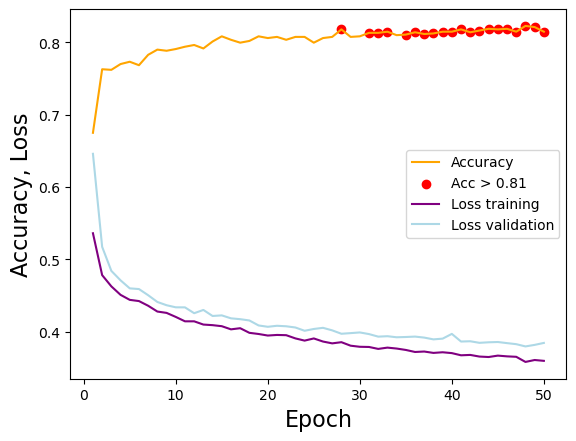

In [ ]:
# plot training metrics for data augmentation

plot_loss_acc(acc_list=acc_list_aug, loss_list=loss_list_aug, loss_val_list=loss_val_list_aug, threshold=0.81, fig_name='cnn_aug.pdf')


---
# Adding residual connections
## (In addition to batch norm, dropout and data augmentation)


In [ ]:
# The model architecture and hyperparamters are the same as before, with batch normalization, dropout and image augmentation

import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Ensure that the residual connection can be correctly added - dimensions
        self.downsample = nn.Sequential() # if dimensions in and out are the same, do nothing
        if stride != 1 or in_channels != out_channels: # otherwise apply conv layer without activation function
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    # define method forward, the layers in the residual block (with batch norm)
    def forward(self, x):
        residual = self.downsample(x) # define residuals
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual # the input skips the two convolutions but is added to their output
        out = self.relu(out)
        return out

# Now that we have ResidualBlock, we can use it with the model (same model as model_aug)
class ResidualModel(nn.Module):
    def __init__(self):
        super(ResidualModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2)
        )

        # Put residual block between the conv layers, define dimensions according to that
        self.resblock1 = ResidualBlock(16, 32, stride=2)

        # Layer 2 activates residual block, and adds batch norm and dropout
        self.layer2 = nn.Sequential(
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2)
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32768, 100)  # Adjust the input size according to the final feature map size
        self.bn3 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.layer1(x) # conv2d -> batch norm -> relu -> maxpool -> dropout
        x = self.resblock1(x) # residual block conv2d -> ... conv2d -> batch norm -> add res -> relu
        x = self.layer2(x) # batch norm -> relu -> dropout
        x = self.flatten(x)
        x = self.fc1(x) # nn.linear
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x) # nn.linear (output)
        return x

model_res = ResidualModel()

# Print model summary
print(model_res)

In [ ]:
# Training residual connections model

model_res = ResidualModel()

# Loss function and optimizer method
loss_fn_res = nn.BCEWithLogitsLoss()
optimizer_res = optim.SGD(model_res.parameters(), lr=0.001, weight_decay=1e-4)

# Train model
acc_list_res, loss_list_res, loss_val_list_res = cnn_train(model_res, loss_fn_res, optimizer_res)


Epoch  1
Loss: 0.5565972497000933, Loss validation set: 0.667344270803677, Accuracy: 0.5
Epoch  2
Loss: 0.49744973571694534, Loss validation set: 0.5374379064709234, Accuracy: 0.7228434504792333
Epoch  3
Loss: 0.47990405982504597, Loss validation set: 0.4705623320687693, Accuracy: 0.7396166134185304
Epoch  4
Loss: 0.46826568290410364, Loss validation set: 0.46214611509356635, Accuracy: 0.7547923322683706
Epoch  5
Loss: 0.4641626872379684, Loss validation set: 0.4548209456209177, Accuracy: 0.7531948881789138
Epoch  6
Loss: 0.45467621221595783, Loss validation set: 0.44935982838606303, Accuracy: 0.7579872204472844
Epoch  7
Loss: 0.45180570615476956, Loss validation set: 0.44761016688788663, Accuracy: 0.7643769968051118
Epoch  8
Loss: 0.4468136623738304, Loss validation set: 0.44532303231211895, Accuracy: 0.7747603833865815
Epoch  9
Loss: 0.43794573383875957, Loss validation set: 0.44030770297629385, Accuracy: 0.7715654952076677
Epoch  10
Loss: 0.43680402315594197, Loss validation set: 0.

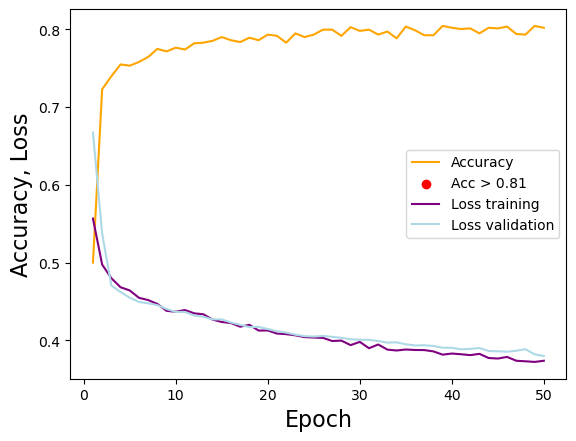

In [ ]:
# Plotting after adding residual connections

plot_loss_acc(acc_list_res, loss_list_res, loss_val_list_res, threshold=0.81, fig_name='cnn_res.pdf') # 0.81 to compare with previous results


---
# Implementing pre-trained models with PyTorch/Torchvision

In [ ]:
# Function to clear memory on local gpu.

import gc
def clear_memory(device):

    def print_cuda_memory():
        allocated_memory = torch.cuda.memory_allocated(device)
        reserved_memory = torch.cuda.memory_reserved(device)
        print(f"Allocated memory: {allocated_memory / (1024 ** 3):.2f} GB")
        print(f"Reserved memory: {reserved_memory / (1024 ** 3):.2f} GB")

    # Before clearing cache
    print("Before clearing cache:")
    print_cuda_memory()

    # Clear cache
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats(device)
    torch.cuda.reset_accumulated_memory_stats(device)
    gc.collect()

    # After clearing cache
    print("After clearing cache:")
    print_cuda_memory()
    print(torch.cuda.memory_summary())

In [ ]:
# Early stopping function to stop when improvment is to low.

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved. Default: 5
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement. Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
# Set up for applying pre-trained model specifik weights on dataset.

from torch.utils.data import DataLoader
from torchvision import models

# Load pre-trained model weights
weights_id = models.ResNet18_Weights.IMAGENET1K_V1

# Define the transforms using pre-trained model's normalization parameters
# Check if weights_id.transforms() needs to be used directly
if hasattr(weights_id, 'transforms'):
    resnet_transforms = weights_id.transforms()
else:
    resnet_transforms = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to the size the model expects
        transforms.ToTensor()
    ])

# Define a common transform function for both training and validation datasets
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size the model expects
    transforms.ToTensor()
])

pre_data_train = datasets.ImageFolder('C:/Users/Freddie/Downloads/train/train', transform=data_transforms)
preTrainDataLoader = DataLoader(pre_data_train, batch_size=256, shuffle=True)
pre_data_val = datasets.ImageFolder('C:/Users/Freddie/Downloads/val/val', transform=data_transforms)
preValDataLoader = DataLoader(pre_data_val, batch_size=256, shuffle=False)
pre_data_test = datasets.ImageFolder('C:/Users/Freddie/Downloads/test/test', transform=data_transforms)
preTestDataLoader = DataLoader(pre_data_test, batch_size=256, shuffle=False)


In [ ]:
# Load and tune the pretrained model

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and modify the pretrained ResNet18 model
res_model = resnet18(pretrained=True)

# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(res_model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 400
not_binary = True

# Run the training
acc, loss, val_loss, trained_model = cnn_gpu_train(not_binary, res_model, num_epochs, loss_fn, optimizer, preTrainDataLoader, preValDataLoader, device)


In [ ]:
# Train with image augmentation in addition to batch normalization and dropout on GPU

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loss function and optimizer method
loss_fn_bn = nn.BCEWithLogitsLoss()
optimizer_bn = optim.SGD(model_bn_dropout.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 400
not_binary = False

# Train model
acc_list_aug, loss_list_aug, loss_val_list_aug, trained_tuned_model = cnn_gpu_train(not_binary, model_bn_dropout, num_epochs, loss_fn_bn, optimizer_bn, trainDataLoader, valDataLoader, device)

In [ ]:
# Training residual connections model on GPU

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_res = ResidualModel()

# Loss function and optimizer method
loss_fn_res = nn.BCEWithLogitsLoss()
optimizer_res = optim.SGD(model_res.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 400
not_binary = False

# Train model
acc_list_aug, loss_list_aug, loss_val_list_aug, trained_tuned_model = cnn_gpu_train(not_binary, model_res, num_epochs, loss_fn_res, optimizer_res, trainDataLoader, valDataLoader, device)

In [ ]:
# check test metrics for all models
models = [model_base, model_bn, model_gn, model_bn_dropout2, model_aug, model_res]

for model in models:
    predictions, true_labels = predict_evaluate(model, testDataLoader)